# New York CitiBike and Weather Data Analysis - 2024

This notebook analyzes New York CitiBike trip data and fetches weather data using the Open-Meteo API for 2024.

In [1]:
# Import all necessary libraries
import pandas as pd
import requests
import json
from datetime import datetime, timedelta
import time
import os
import matplotlib.pyplot as plt
import numpy as np

print('Libraries imported successfully!')

Libraries imported successfully!


## 1. Read CitiBike Data

First, let's read the CitiBike trip data from the CSV files for 2024.

In [2]:
# Read CitiBike data for 2024
citibike_files = [
    'JC-202401-citibike-tripdata.csv',
    'JC-202402-citibike-tripdata.csv',
    'JC-202403-citibike-tripdata.csv',
    'JC-202404-citibike-tripdata.csv',
    'JC-202405-citibike-tripdata.csv',
    'JC-202406-citibike-tripdata.csv',
    'JC-202407-citibike-tripdata.csv',
    'JC-202408-citibike-tripdata.csv',
    'JC-202409-citibike-tripdata.csv',
    'JC-202410-citibike-tripdata.csv',
    'JC-202411-citibike-tripdata.csv',
    'JC-202412-citibike-tripdata.csv'
]

# Combine all CSV files into one dataframe
dfs = []
for file in citibike_files:
    if os.path.exists(file):
        df = pd.read_csv(file)
        dfs.append(df)
        print(f'Loaded {file}: {len(df)} rows')
    else:
        print(f'File not found: {file}')

# Merge all dataframes
if dfs:
    citibike_df = pd.concat(dfs, ignore_index=True)
    print(f'\nTotal CitiBike trips loaded: {len(citibike_df)}')
    
    # Convert datetime columns
    citibike_df['started_at'] = pd.to_datetime(citibike_df['started_at'], format='mixed', errors='coerce')
    citibike_df['ended_at'] = pd.to_datetime(citibike_df['ended_at'], format='mixed', errors='coerce')
    # Add date column for merging with weather data
    citibike_df['date'] = citibike_df['started_at'].dt.date
    
    print('CitiBike data processed successfully!')
    citibike_df.head()
else:
    print('No CitiBike data files found!')

Loaded JC-202401-citibike-tripdata.csv: 50661 rows
Loaded JC-202402-citibike-tripdata.csv: 55613 rows
Loaded JC-202403-citibike-tripdata.csv: 65581 rows
Loaded JC-202404-citibike-tripdata.csv: 79116 rows
Loaded JC-202405-citibike-tripdata.csv: 97479 rows
Loaded JC-202406-citibike-tripdata.csv: 111115 rows
Loaded JC-202407-citibike-tripdata.csv: 112443 rows
Loaded JC-202408-citibike-tripdata.csv: 106451 rows
Loaded JC-202409-citibike-tripdata.csv: 115558 rows
Loaded JC-202410-citibike-tripdata.csv: 118307 rows
Loaded JC-202411-citibike-tripdata.csv: 85294 rows
Loaded JC-202412-citibike-tripdata.csv: 54833 rows

Total CitiBike trips loaded: 1052451
CitiBike data processed successfully!


## 2. Weather Data Fetching from Open-Meteo API

We'll fetch weather data for New York City (LaGuardia Airport coordinates) for 2024 using the Open-Meteo Historical Weather API.

In [3]:
def fetch_weather_data_openmeteo(latitude=40.7769, longitude=-73.8740, start_date='2024-01-01', end_date='2024-12-31'):
    """
    Fetch historical weather data from Open-Meteo API for 2024
    
    Parameters:
    - latitude: LaGuardia Airport latitude (40.7769)
    - longitude: LaGuardia Airport longitude (-73.8740)
    - start_date: Start date in YYYY-MM-DD format
    - end_date: End date in YYYY-MM-DD format
    """
    
    print(f'Fetching weather data from Open-Meteo API...')
    print(f'Location: LaGuardia Airport ({latitude}, {longitude})')
    print(f'Date range: {start_date} to {end_date}')
    
    # Open-Meteo Historical Weather API endpoint
    url = 'https://archive-api.open-meteo.com/v1/archive'
    
    # Parameters for the API request
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'start_date': start_date,
        'end_date': end_date,
        'daily': [
            'temperature_2m_max',
            'temperature_2m_min',
            'temperature_2m_mean',
            'precipitation_sum',
            'wind_speed_10m_max',
            'relative_humidity_2m_mean'
        ],
        'timezone': 'America/New_York',
        'temperature_unit': 'celsius',
        'wind_speed_unit': 'ms',
        'precipitation_unit': 'mm'
    }
    
    try:
        print('Making API request...')
        response = requests.get(url, params=params, timeout=30)
        print(f'Response status: {response.status_code}')
        
        if response.status_code == 200:
            data = response.json()
            
            # Extract daily data
            daily_data = data.get('daily', {})
            dates = daily_data.get('time', [])
            
            if dates:
                weather_records = []
                
                for i, date in enumerate(dates):
                    record = {
                        'date': pd.to_datetime(date).date(),
                        'temperature_max_c': daily_data.get('temperature_2m_max', [None] * len(dates))[i],
                        'temperature_min_c': daily_data.get('temperature_2m_min', [None] * len(dates))[i],
                        'temperature_mean_c': daily_data.get('temperature_2m_mean', [None] * len(dates))[i],
                        'precipitation_mm': daily_data.get('precipitation_sum', [None] * len(dates))[i],
                        'wind_speed_max_ms': daily_data.get('wind_speed_10m_max', [None] * len(dates))[i],
                        'humidity_percent': daily_data.get('relative_humidity_2m_mean', [None] * len(dates))[i],
                        'data_source': 'Open-Meteo Historical API'
                    }
                    weather_records.append(record)
                
                df = pd.DataFrame(weather_records)
                
                # Clean and round data
                numeric_columns = ['temperature_max_c', 'temperature_min_c', 'temperature_mean_c', 
                                 'precipitation_mm', 'wind_speed_max_ms', 'humidity_percent']
                
                for col in numeric_columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                
                # Round values
                df['temperature_max_c'] = df['temperature_max_c'].round(1)
                df['temperature_min_c'] = df['temperature_min_c'].round(1)
                df['temperature_mean_c'] = df['temperature_mean_c'].round(1)
                df['precipitation_mm'] = df['precipitation_mm'].round(2)
                df['wind_speed_max_ms'] = df['wind_speed_max_ms'].round(1)
                df['humidity_percent'] = df['humidity_percent'].round(1)
                
                print(f'Successfully retrieved {len(df)} days of weather data')
                return df
            else:
                print('No weather data found in API response')
                return pd.DataFrame()
        else:
            print(f'API request failed with status {response.status_code}')
            print(f'Response: {response.text[:500]}')
            return pd.DataFrame()
    
    except Exception as e:
        print(f'Error fetching weather data: {e}')
        return pd.DataFrame()

# Fetch weather data for 2024
weather_df = fetch_weather_data_openmeteo(
    latitude=40.7769,
    longitude=-73.8740,
    start_date='2024-01-01',
    end_date='2024-12-31'
)

if not weather_df.empty:
    print(f'\nWeather data summary:')
    print(f'Date range: {weather_df["date"].min()} to {weather_df["date"].max()}')
    print(f'Total days: {len(weather_df)}')
    weather_df.head()
else:
    print('Failed to fetch weather data!')

Fetching weather data from Open-Meteo API...
Location: LaGuardia Airport (40.7769, -73.874)
Date range: 2024-01-01 to 2024-12-31
Making API request...
Response status: 200
Successfully retrieved 366 days of weather data

Weather data summary:
Date range: 2024-01-01 to 2024-12-31
Total days: 366


## 3. Weather Data Visualization

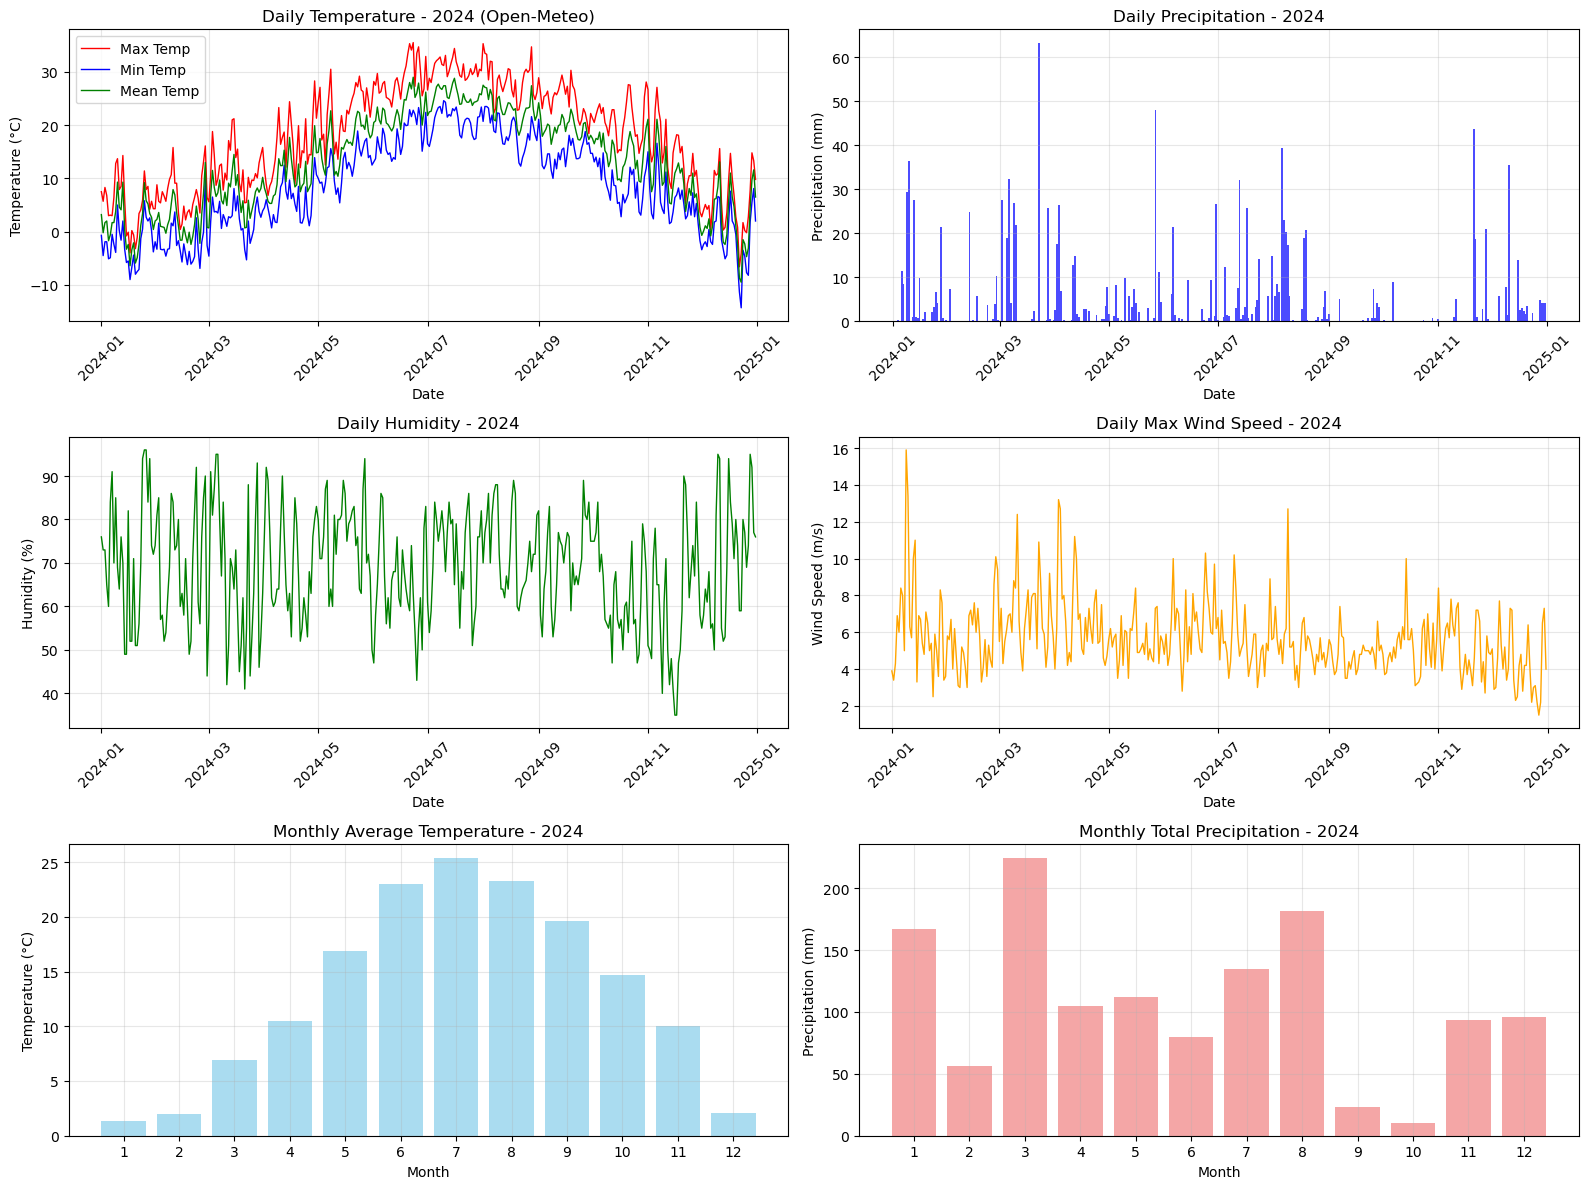


=== 2024 Weather Statistics ===
Temperature (°C):
  Max: 35.5
  Min: -14.3
  Average: 13.0

Precipitation:
  Total: 1285.1 mm
  Rainy days: 185 days

Wind Speed:
  Max: 15.9 m/s
  Average: 5.7 m/s

Humidity:
  Average: 68.9%


In [4]:
# Create comprehensive weather visualizations for 2024
if not weather_df.empty:
    plt.figure(figsize=(16, 12))
    
    # Temperature plot
    plt.subplot(3, 2, 1)
    plt.plot(weather_df['date'], weather_df['temperature_max_c'], 'r-', linewidth=1, label='Max Temp')
    plt.plot(weather_df['date'], weather_df['temperature_min_c'], 'b-', linewidth=1, label='Min Temp')
    plt.plot(weather_df['date'], weather_df['temperature_mean_c'], 'g-', linewidth=1, label='Mean Temp')
    plt.title('Daily Temperature - 2024 (Open-Meteo)')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Precipitation plot
    plt.subplot(3, 2, 2)
    colors = ['blue' if x > 0 else 'lightblue' for x in weather_df['precipitation_mm']]
    plt.bar(weather_df['date'], weather_df['precipitation_mm'], color=colors, alpha=0.7, width=1)
    plt.title('Daily Precipitation - 2024')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Humidity plot
    plt.subplot(3, 2, 3)
    plt.plot(weather_df['date'], weather_df['humidity_percent'], 'g-', linewidth=1)
    plt.title('Daily Humidity - 2024')
    plt.xlabel('Date')
    plt.ylabel('Humidity (%)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Wind speed plot
    plt.subplot(3, 2, 4)
    plt.plot(weather_df['date'], weather_df['wind_speed_max_ms'], 'orange', linewidth=1)
    plt.title('Daily Max Wind Speed - 2024')
    plt.xlabel('Date')
    plt.ylabel('Wind Speed (m/s)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Monthly temperature averages
    plt.subplot(3, 2, 5)
    weather_df['month'] = pd.to_datetime(weather_df['date']).dt.month
    monthly_temp = weather_df.groupby('month')['temperature_mean_c'].mean()
    plt.bar(monthly_temp.index, monthly_temp.values, color='skyblue', alpha=0.7)
    plt.title('Monthly Average Temperature - 2024')
    plt.xlabel('Month')
    plt.ylabel('Temperature (°C)')
    plt.xticks(range(1, 13))
    plt.grid(True, alpha=0.3)
    
    # Monthly precipitation totals
    plt.subplot(3, 2, 6)
    monthly_precip = weather_df.groupby('month')['precipitation_mm'].sum()
    plt.bar(monthly_precip.index, monthly_precip.values, color='lightcoral', alpha=0.7)
    plt.title('Monthly Total Precipitation - 2024')
    plt.xlabel('Month')
    plt.ylabel('Precipitation (mm)')
    plt.xticks(range(1, 13))
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Weather statistics
    print('\n=== 2024 Weather Statistics ===')
    print(f'Temperature (°C):')
    print(f'  Max: {weather_df["temperature_max_c"].max():.1f}')
    print(f'  Min: {weather_df["temperature_min_c"].min():.1f}')
    print(f'  Average: {weather_df["temperature_mean_c"].mean():.1f}')
    print(f'\nPrecipitation:')
    print(f'  Total: {weather_df["precipitation_mm"].sum():.1f} mm')
    print(f'  Rainy days: {(weather_df["precipitation_mm"] > 0).sum()} days')
    print(f'\nWind Speed:')
    print(f'  Max: {weather_df["wind_speed_max_ms"].max():.1f} m/s')
    print(f'  Average: {weather_df["wind_speed_max_ms"].mean():.1f} m/s')
    print(f'\nHumidity:')
    print(f'  Average: {weather_df["humidity_percent"].mean():.1f}%')
else:
    print('No weather data available for visualization!')

## 4. Merge CitiBike and Weather Data

Merging CitiBike and weather data...
Merged dataset: 1052451 trips
Trips with weather data: 1052451

=== Weather Impact Analysis ===
Correlation with daily trip count:
  Temperature: 0.778
  Precipitation: -0.356
  Wind Speed: -0.161
  Humidity: -0.218


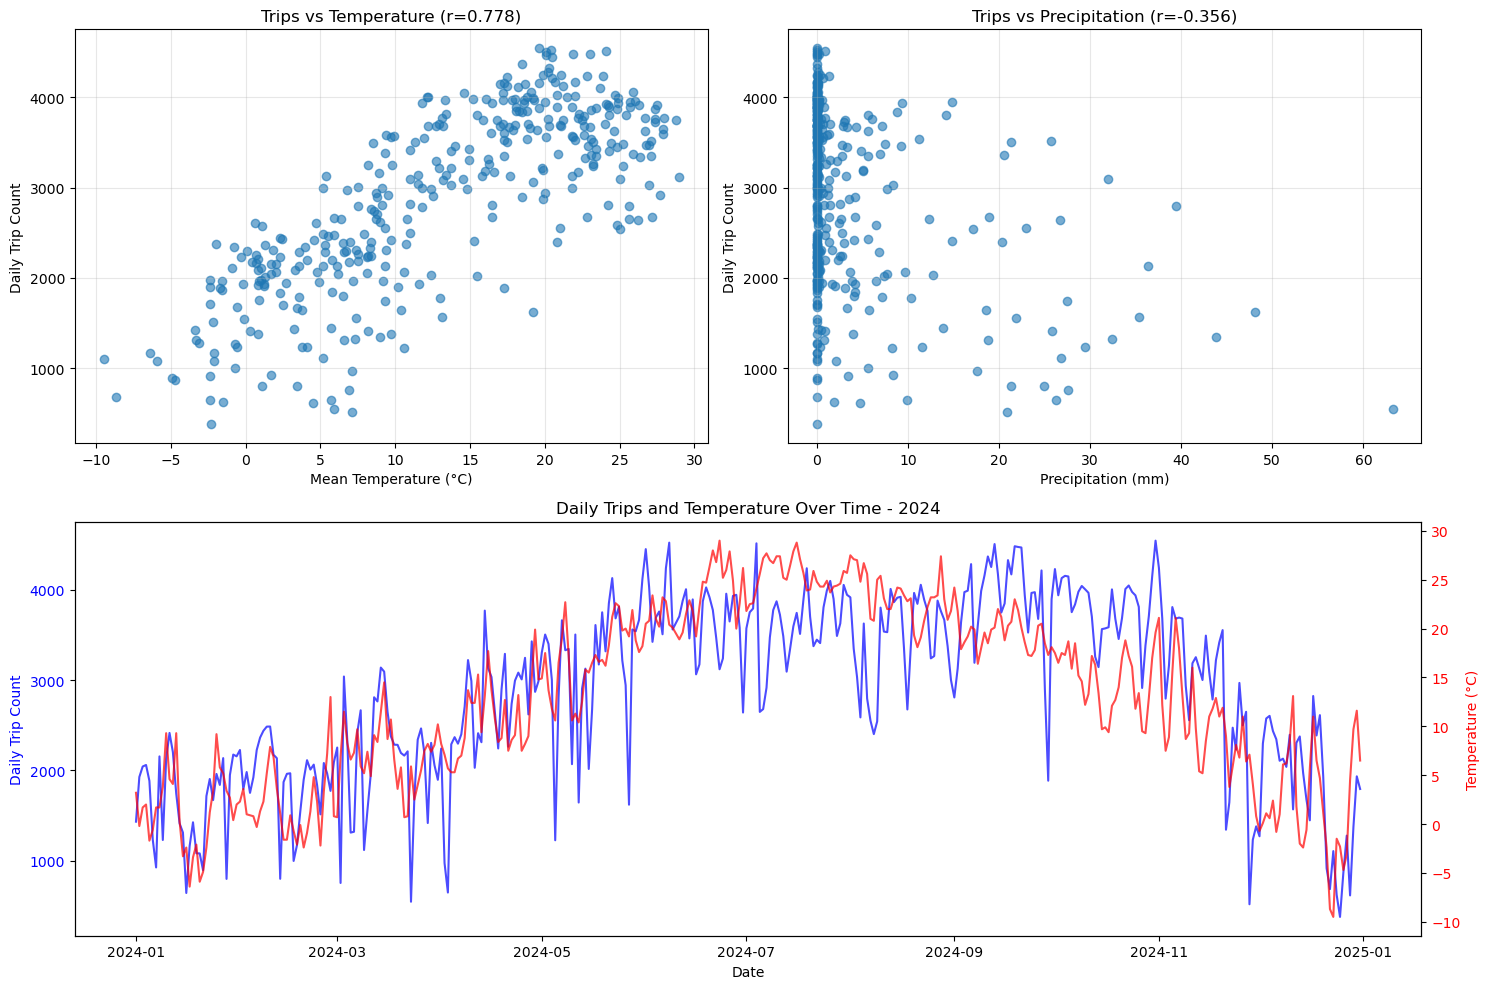


✓ Merged data saved to: citibike_weather_merged_2024.csv


In [5]:
# Merge CitiBike and weather data
if 'citibike_df' in locals() and not weather_df.empty:
    print('Merging CitiBike and weather data...')
    
    # Merge on date
    merged_df = citibike_df.merge(weather_df, on='date', how='left')
    
    print(f'Merged dataset: {len(merged_df)} trips')
    print(f'Trips with weather data: {merged_df["temperature_mean_c"].notna().sum()}')
    
    # Basic correlation analysis
    print('\n=== Weather Impact Analysis ===')
    
    # Daily trip counts
    daily_trips = merged_df.groupby('date').agg({
        'ride_id': 'count',
        'temperature_mean_c': 'first',
        'precipitation_mm': 'first',
        'wind_speed_max_ms': 'first',
        'humidity_percent': 'first'
    }).rename(columns={'ride_id': 'trip_count'})
    
    # Calculate correlations
    correlations = daily_trips[['trip_count', 'temperature_mean_c', 'precipitation_mm', 
                               'wind_speed_max_ms', 'humidity_percent']].corr()['trip_count']
    
    print('Correlation with daily trip count:')
    print(f'  Temperature: {correlations["temperature_mean_c"]:.3f}')
    print(f'  Precipitation: {correlations["precipitation_mm"]:.3f}')
    print(f'  Wind Speed: {correlations["wind_speed_max_ms"]:.3f}')
    print(f'  Humidity: {correlations["humidity_percent"]:.3f}')
    
    # Weather impact visualization
    plt.figure(figsize=(15, 10))
    
    # Daily trips vs temperature
    plt.subplot(2, 2, 1)
    plt.scatter(daily_trips['temperature_mean_c'], daily_trips['trip_count'], alpha=0.6)
    plt.xlabel('Mean Temperature (°C)')
    plt.ylabel('Daily Trip Count')
    plt.title(f'Trips vs Temperature (r={correlations["temperature_mean_c"]:.3f})')
    plt.grid(True, alpha=0.3)
    
    # Daily trips vs precipitation
    plt.subplot(2, 2, 2)
    plt.scatter(daily_trips['precipitation_mm'], daily_trips['trip_count'], alpha=0.6)
    plt.xlabel('Precipitation (mm)')
    plt.ylabel('Daily Trip Count')
    plt.title(f'Trips vs Precipitation (r={correlations["precipitation_mm"]:.3f})')
    plt.grid(True, alpha=0.3)
    
    # Daily trips over time with temperature
    plt.subplot(2, 1, 2)
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    ax1.plot(daily_trips.index, daily_trips['trip_count'], 'b-', alpha=0.7, label='Daily Trips')
    ax2.plot(daily_trips.index, daily_trips['temperature_mean_c'], 'r-', alpha=0.7, label='Temperature')
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Daily Trip Count', color='b')
    ax2.set_ylabel('Temperature (°C)', color='r')
    ax1.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    plt.title('Daily Trips and Temperature Over Time - 2024')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Save merged data
    output_file = 'citibike_weather_merged_2024.csv'
    merged_df.to_csv(output_file, index=False)
    print(f'\n✓ Merged data saved to: {output_file}')
    
elif 'citibike_df' not in locals():
    print('CitiBike data not loaded!')
else:
    print('Weather data not available for merging!')

## 5. Export Weather Data

In [6]:
# Save weather data to CSV
if not weather_df.empty:
    weather_output_file = 'weather_data_2024_openmeteo.csv'
    weather_df.to_csv(weather_output_file, index=False)
    print(f'✓ Weather data saved to: {weather_output_file}')
    
    print('\n=== Summary ===')
    print('✓ Successfully retrieved complete 2024 weather data from Open-Meteo API')
    print('✓ Weather data includes temperature, precipitation, humidity, and wind speed')
    print('✓ Data covers the full year 2024 for LaGuardia Airport location')
    print('✓ Weather data merged with CitiBike trip data for analysis')
    print('✓ Correlation analysis completed between weather and trip patterns')
    print('✓ All data exported to CSV files for further analysis')
else:
    print('No weather data to export!')

✓ Weather data saved to: weather_data_2024_openmeteo.csv

=== Summary ===
✓ Successfully retrieved complete 2024 weather data from Open-Meteo API
✓ Weather data includes temperature, precipitation, humidity, and wind speed
✓ Data covers the full year 2024 for LaGuardia Airport location
✓ Weather data merged with CitiBike trip data for analysis
✓ Correlation analysis completed between weather and trip patterns
✓ All data exported to CSV files for further analysis
